In [1]:
import itertools

import pymc3 as pm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pyjags

import mcmc_utils
import plot_utils

In [2]:
TRACE_LENGTH = 10_000
CHAINS = 4

# Exercise 1

Reading data from csv file: 3 subjects, multiple samples per subject.

Infer the subjects proportion, individually, and compare to each other.

In [3]:
data = pd.read_csv('data/ch08_ex1_demo_data.csv', dtype={'subject': 'category'})
data.head()

,subject,y
0,moshe,1
1,moshe,1
2,moshe,0
3,moshe,0
4,moshe,1


### PyMC3

In [4]:
with pm.Model() as model:

    # Model definition
    theta = {s: pm.Beta(f'theta_{s}', 2, 2) for s in data['subject'].unique()}
    for i, row in data.iterrows():
        pm.Bernoulli(f'y_{i}', theta[row['subject']], observed=row['y'])

    # Inference
    pymc3_trace = pm.sample(TRACE_LENGTH, chains=CHAINS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta_yossi, theta_jacob, theta_moshe]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


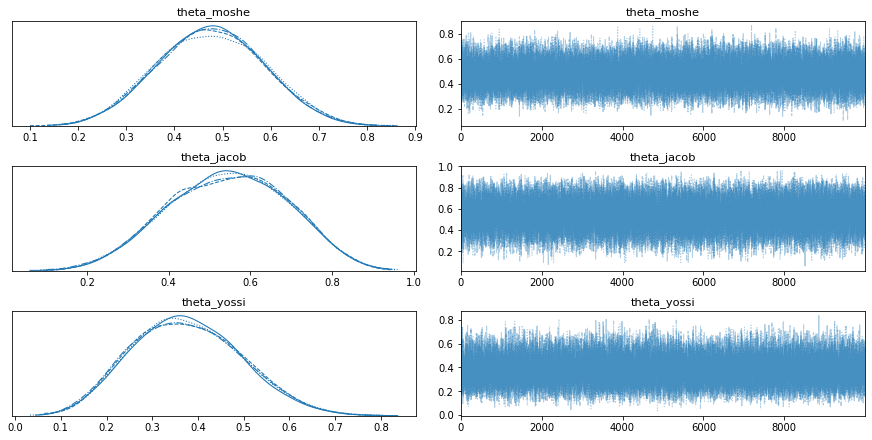

In [5]:
pm.traceplot(pymc3_trace);

### Now with pyjags

In [6]:
code = """
model {
    for (i in 1:Ntotal) {
        y[i] ~ dbern(theta[s[i]])
    }
    for (sIdx in 1:Nsubj) {
        theta[sIdx] ~ dbeta(2, 2)
    }
}
"""

jags_data = {
    'Ntotal': len(data),
    'Nsubj': len(data['subject'].unique()),
    'y': data['y'].values,
    's': data['subject'].cat.codes.values + 1,  # Because JAGS indices start from 1
}

In [7]:
model = pyjags.Model(code=code, data=jags_data, chains=CHAINS)

In [8]:
model.update(500)  # burn-in

updating: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00


In [9]:
jags_trace = model.sample(
    vars=['theta'],
    iterations=TRACE_LENGTH,
)

sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00


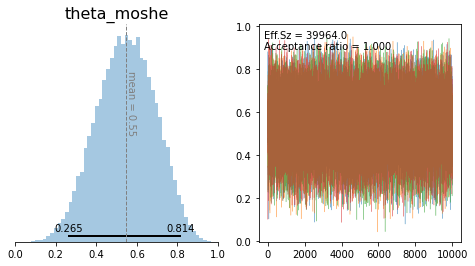

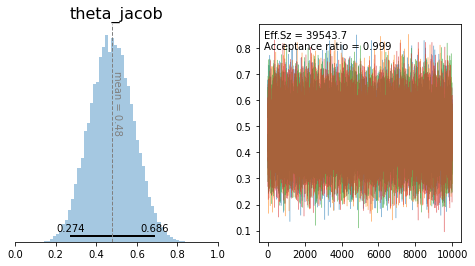

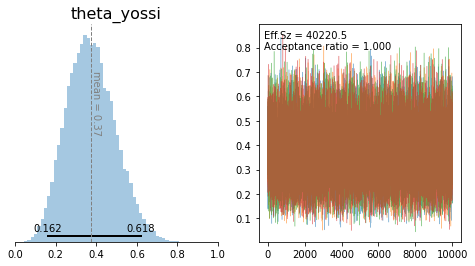

In [10]:
for trace, subject in zip(jags_trace['theta'], data['subject'].unique()):
    (ax, *_) = plot_utils.trace(trace)
    ax.set_title(f'theta_{subject}', fontsize=16)
    ax.set_xlim(0, 1)

Don't know why but JAGS is so much faster than PyMC3 in this case.

# Exercise 4

Explore difference between parameters with various priors.

In [11]:
def explore_prior(theta_a_beta_params, theta_b_beta_params):

    with pm.Model() as model:
        # Model definition
        theta_a = pm.Beta('theta_a', *theta_a_beta_params)
        theta_b = pm.Beta('theta_b', *theta_b_beta_params)

        # Sampling the prior
        trace = pm.sample(TRACE_LENGTH, chains=CHAINS)

    data = pd.DataFrame({t: trace.get_values(t) for t in ('theta_a', 'theta_b')})

    # Plot
    sns.jointplot('theta_a', 'theta_b', data, kind="hex", stat_func=None)

    plt.figure()
    sns.distplot(data['theta_a'] - data['theta_b'])
    plt.suptitle('theta_a - theta_b')

## Question A

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta_b, theta_a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.


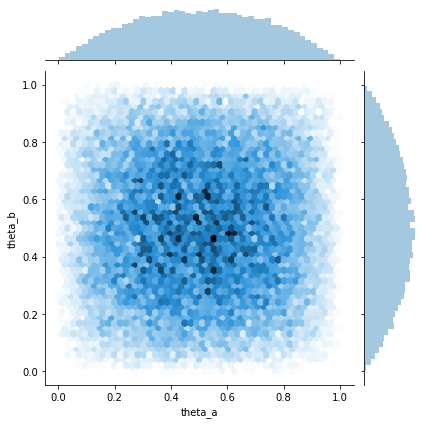

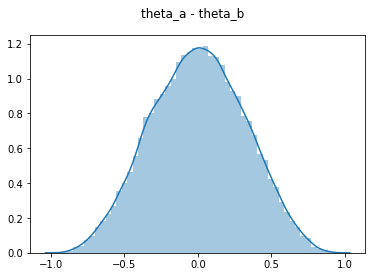

In [12]:
explore_prior(theta_a_beta_params=(2, 2), theta_b_beta_params=(2, 2))

## Question B

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta_b, theta_a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 16 seconds.


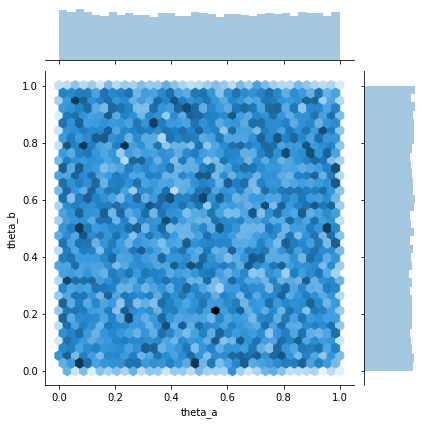

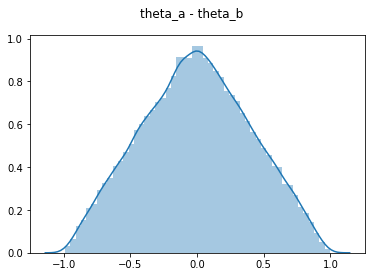

In [13]:
explore_prior(theta_a_beta_params=(1, 1), theta_b_beta_params=(1, 1))

## Question C

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta_b, theta_a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


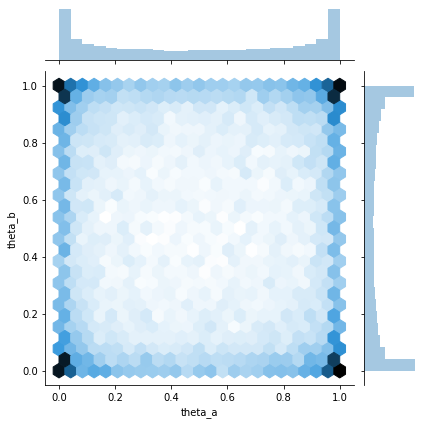

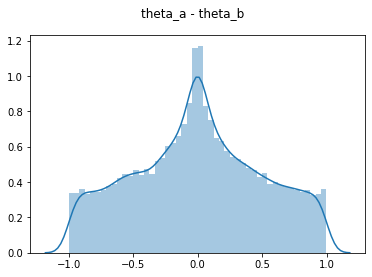

In [14]:
explore_prior(theta_a_beta_params=(.5, .5), theta_b_beta_params=(.5, .5))